# **Identifying Key Entities in Recipe Data**


**Business Objective**:
The goal of this assignment is to train a Named Entity Recognition (NER) model using Conditional Random Fields (CRF) to extract key entities from recipe data. The model will classify words into predefined categories such as ingredients, quantities and units, enabling the creation of a structured database of recipes and ingredients that can be used to power advanced features in recipe management systems, dietary tracking apps, or e-commerce platforms.

### **Data Description**
The given data is in JSON format, representing a **structured recipe ingredient list** with **Named Entity Recognition (NER) labels**. Below is a breakdown of the data fields:

```json
[
    {
        "input": "6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil",
        "pos": "quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient"
    },
    {
      "input": "2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida",
      "pos": "quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient"
    }
]


| **Key**  | **Description**  |
|----------|-----------------|
| `input`  | Contains a raw ingredient list from a recipe. |
| `pos`    | Represents the corresponding part-of-speech (POS) tags or NER labels, identifying quantities, ingredients, and units. |


## **1** Import libraries

#### **1.1** Installation of sklearn-crfsuite

sklearn-crfsuite is a Python wrapper for CRFsuite, a fast and efficient implementation of Conditional Random Fields (CRFs). It is designed to integrate seamlessly with scikit-learn for structured prediction tasks such as Named Entity Recognition (NER), Part-of-Speech (POS) tagging, and chunking.

In [17]:
# installation of sklearn_crfsuite
!pip install sklearn_crfsuite==0.5.0

#### **1.2** Import necessary libraries

In [18]:
# Import warnings
import warnings
warnings.filterwarnings('ignore')

In [19]:
# Import necessary libraries
import json  # For handling JSON data
import pandas as pd  # For data manipulation and analysis
import re  # For regular expressions (useful for text preprocessing)
import matplotlib.pyplot as plt  # For visualisation
import seaborn as sns  # For advanced data visualisation
import sklearn_crfsuite  # CRF (Conditional Random Fields) implementation for sequence modeling
import numpy as np  # For numerical computations
# Saving and loading machine learning models
import joblib
import random
import spacy
from IPython.display import display, Markdown # For displaying well-formatted output

from fractions import Fraction  # For handling fractional values in numerical data
# Importing tools for feature engineering and model training
from collections import Counter  # For counting occurrences of elements in a list
from sklearn.model_selection import train_test_split  # For splitting dataset into train and test sets
from sklearn_crfsuite import metrics  # For evaluating CRF models
from sklearn_crfsuite.metrics import flat_classification_report
from sklearn.utils.class_weight import compute_class_weight
from collections import Counter
from sklearn.metrics import confusion_matrix
import spacy
nlp = spacy.load("en_core_web_sm")
from sklearn.metrics import classification_report, confusion_matrix
import itertools

In [20]:
# Ensure pandas displays full content
pd.set_option('display.max_colwidth', None)
pd.set_option('display.expand_frame_repr', False)

## **2** Data Ingestion and Preparation <font color = red>[25 marks]</font> <br>

#### **2.1** *Read Recipe Data from Dataframe and prepare the data for analysis* <font color = red>[12 marks]</font> <br>
Read the data from JSON file, print first five rows and describe the dataframe

##### **2.1.1** **Define a *load_json_dataframe* function** <font color = red>[7 marks]</font> <br>

Define a function that takes path of the ingredient_and_quantity.json file and reads it, convert it into dataframe - df and return it.

In [21]:
# define a function to load json file to a dataframe
def load_json_dataframe(file_path):

  try:
      with open(file_path,"r") as file:
          data = json.load(file)
          df = pd.DataFrame(data)
          return df
  except FileNotFoundError:
      print(f"The file '{file_path}'was not found.")
      return pd.DataFrame()
  except json.JSONDecodeError:
      print(f"Could not decode the JSON file")
      return pd.DataFrame()
  except Exception as e:
      print(f"Unexpected Error Occored")
      return pd.DataFrame()

##### **2.1.2** **Execute the *load_json_dataframe* function** <font color = red>[2 marks]</font> <br>

In [22]:
# read the json file by giving the file path and create a dataframe
import os
from google.colab import drive
drive.mount('/content/drive')
os.chdir("/content/drive/My Drive/Colab Notebooks/NLP")
print(os.getcwd())

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
/content/drive/My Drive/Colab Notebooks/NLP


In [23]:
df = load_json_dataframe('ingredient_and_quantity.json')

##### **2.1.3** **Describe the dataframe** <font color = red>[3 marks]</font> <br>

Print first five rows of dataframe along with dimensions. Display the information of dataframe

In [24]:
# display first five rows of the dataframe - df
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

In [25]:
# print the dimensions of dataframe - df
df.shape

(285, 2)

In [26]:
# print the information of the dataframe
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 285 entries, 0 to 284
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   input   285 non-null    object
 1   pos     285 non-null    object
dtypes: object(2)
memory usage: 4.6+ KB


#### **2.2** *Recipe Data Manipulation* <font color = red>[13 marks]</font> <br>
Create derived metrics in dataframe and provide insights of the dataframe

##### **2.2.1** **Create input_tokens and pos_tokens columns by splitting the input and pos from the dataframe** <font color = red>[3 marks]</font> <br>
Split the input and pos into input_tokens and pos_tokens in the dataframe and display it in the dataframe

In [27]:
# display first five rows of the dataframe - df
df.head()


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient
2                                                                  1-1/2 cups Rice Vermicelli Noodles Thin 1 Onion sliced 1/2 cup Carrots Gajjar chopped 1/3 Green peas Matar 2 Chillies 1/4 teaspoon Asafoetida hing Mustard seeds White Urad Dal Split Ghee sprig Curry leaves Salt Lemon juice                                                                                       quantity unit ingredient ingredient ingredient ingredient quantity ingredient ingredient quantity unit ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
3  500 grams Chicken 2 Onion chopped 1 Tomato 4 Green Chillies slit inch Ginger finely 6 cloves Garlic 1/2 teaspoon Turmeric powder Haldi Garam masala tablespoon Sesame Gingelly Oil 1/4 Methi Seeds Fenugreek Coriander Dhania Dry Red Fennel seeds Saunf cups Sorrel Leaves Gongura picked and  quantity unit ingredient quantity ingredient ingredient quantity ingredient quantity ingredient ingredient ingredient unit ingredient ingredient quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient
4                                                                                                                                                           1 tablespoon chana dal white urad 2 red chillies coriander seeds 3 inches ginger onion tomato Teaspoon mustard asafoetida sprig curry                                                                                                                                                                                                                                                                 qua

##### **2.2.2** **Provide the length for input_tokens and pos_tokens and validate their length** <font color = red>[2 marks]</font> <br>

Create input_length and pos_length columns in the dataframe and validate both the lengths. Check for the rows that are unequal in input and pos length


In [28]:
# split the input and pos into input_tokens and pos_tokens in the dataframe

# Tokenize input
# Tokenize POS
df['input_tokens'] = df['input'].str.split(' ')
df['pos_tokens'] = df['pos'].str.split(' ')


In [29]:
# create input_length and pos_length columns for the input_tokens and pos-tokens
df["input_length"] = df["input_tokens"].str.len()
df["pos_length"] = df["pos_tokens"].str.len()
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablesp

In [30]:
# check for the equality of input_length and pos_length in the dataframe
df[df["input_length"] != df["pos_length"]]


input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        pos                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length
17                                                                                                                                                                                                                                                                                                                                                                            2 cups curd 1 cup gourd cucumber green cor coriander 1/2 teaspoon cumin powder salt                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          quantity unit ingredient quantity unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient ingredient                                                                                                                                                                                                                                                                                                                                                                                                                                     [2, cups, curd, 1, cup, gourd, cucumber, green, cor, coriander, 1/2, teaspoon, cumin, powder, salt]                                                                                                                                                                                                                     

##### **2.2.3** **Define a unique_labels function and validate the labels in pos_tokens** <font color = red>[2 marks]</font> <br>

Define a unique_labels function which checks for all the unique pos labels in the recipe & execute it.


In [31]:
# Define a unique_labels function to checks for all the unique pos labels in the recipe & print it
def unique_pos_labels(df):
  all_tokens = [token for sublist in df['pos_tokens'] for token in sublist]
  unique_tokens = set(all_tokens)
  return unique_tokens

In [32]:
print(unique_pos_labels(df))

{'unit', 'ingredient', 'quantity'}


##### **2.2.3** **Provide the insights seen in the recipe data after validation** <font color = red>[1 marks]</font> <br>

Provide the indexes that requires cleaning and formatting in the dataframe

<font color = red>[write your answer]</font> <br>


In [33]:
row_index = df[df["input_length"] != df["pos_length"]].index
print(f"The index of the rows which need cleaning: {row_index}")


The index of the rows which need cleaning: Index([17, 27, 79, 164, 207, 268], dtype='int64')


##### **2.2.4** **Drop the rows that have invalid data provided in previous cell** <font color = red> [2 marks]</font> <br>

In [34]:
# drop the irrelevant recipe data
row_index_list = list(row_index)
df = df.drop(row_index_list)
df.sort_index(inplace=True)

In [35]:
row_index = df[df["input_length"] != df["pos_length"]].index
print(f"The index of the rows which need cleaning: {row_index}")

The index of the rows which need cleaning: Index([], dtype='int64')


##### **2.2.5** **Update the input_length & pos_length in dataframe**<font color = red> [2 marks]</font> <br>

In [36]:
# update the input and pos length in input_length and pos_length
df["input_length"] = df["input_tokens"].str.len()
df["pos_length"] = df["pos_tokens"].str.len()
df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                      pos                                                                                                                                                                                                                                                                                                                                   input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
0                                                                                                 6 Karela Bitter Gourd Pavakkai Salt 1 Onion 3 tablespoon Gram flour besan 2 teaspoons Turmeric powder Haldi Red Chilli Cumin seeds Jeera Coriander Powder Dhania Amchur Dry Mango Sunflower Oil                                                                                                                                         quantity ingredient ingredient ingredient ingredient ingredient quantity ingredient quantity unit ingredient ingredient ingredient quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                [6, Karela, Bitter, Gourd, Pavakkai, Salt, 1, Onion, 3, tablespoon, Gram, flour, besan, 2, teaspoons, Turmeric, powder, Haldi, Red, Chilli, Cumin, seeds, Jeera, Coriander, Powder, Dhania, Amchur, Dry, Mango, Sunflower, Oil]                                                                                                                                                        [quantity, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, quantity, unit, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            31          31
1                                                                                    2-1/2 cups rice cooked 3 tomatoes teaspoons BC Belle Bhat powder 1 teaspoon chickpea lentils 1/2 cumin seeds white urad dal mustard green chilli dry red 2 cashew or peanuts 1-1/2 tablespoon oil asafoetida                                                                                                                        quantity unit ingredient ingredient quantity ingredient unit ingredient ingredient ingredient ingredient quantity unit ingredient ingredient quantity ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient ingredient quantity unit ingredient ingredient                                                                                                [2-1/2, cups, rice, cooked, 3, tomatoes, teaspoons, BC, Belle, Bhat, powder, 1, teaspoon, chickpea, lentils, 1/2, cumin, seeds, white, urad, dal, mustard, green, chilli, dry, red, 2, cashew, or, peanuts, 1-1/2, tablesp

##### **2.2.6** **Validate the input_length and pos_length by checking unequal rows** <font color = red> [1 marks]</font> <br>

In [37]:
# validate the input length and pos length as input_length and pos_length
df[df["input_length"] != df["pos_length"]]

Empty DataFrame
Columns: [input, pos, input_tokens, pos_tokens, input_length, pos_length]
Index: []

## **3** Train Validation Split (70 train - 30 val) <font color = red>[6 marks]</font> <br>

#### **3.1** *Perform train and validation split ratio* <font color = red>[6 marks]</font> <br>
Split the dataset with the help of input_tokens and pos_tokens and make a ratio of 70:30 split for training and validation datasets.

###### **3.1.1** **Split the dataset into train_df and val_df into 70:30 ratio** <font color = red> [1 marks]</font> <br>

In [38]:
# split the dataset into training and validation sets
train_df, val_df = train_test_split(
    df,
    test_size=0.3,
    random_state=42
)

###### **3.1.2** **Print the first five rows of train_df and val_df** <font color = red> [1 marks]</font> <br>

In [39]:
# print the first five rows of train_df
train_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                             pos                                                                                                                                                                                                                                                                                                            input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                              pos_tokens  input_length  pos_length
40                                                                                                                                                                                                                   2 cups Water 1 teaspoon Tea leaves 1/4 Milk 10 Saffron strands                                                                                                                                                                                                                                                                                                 quantity unit ingredient quantity unit ingredient ingredient quantity ingredient quantity ingredient ingredient                                                                                                                                                                                                                                             [2, cups, Water, 1, teaspoon, Tea, leaves, 1/4, Milk, 10, Saffron, strands]                                                                                                                                                                                                                                                                                                                            [quantity, unit, ingredient, quantity, unit, ingredient, ingredient, quantity, ingredient, quantity, ingredient, ingredient]            12          12
174  1/2 cup Instant Oats Oatmeal Wheat Flakes Cereal 3 tablespoon Pine nuts tablespoons Pumpkin seeds Dates dried ones finely chopped Dried raspberries Raisins sultana Badam Almond Walnuts teaspoon Cinnamon Powder Dalchini Nutmeg powder Vanilla Extract Sunflower Oil 1 Honey  quantity unit ingredient ingredient ingredient ingredient ingredient ingredient quantity unit ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient  [1/2, cup, Instant, Oats, Oatmeal, Wheat, Flakes, Cereal, 3, tablespoon, Pine, nuts, tablespoons, Pumpkin, seeds, Dates, dried, ones, finely, chopped, Dried, raspberries, Raisins, sultana, Badam, Almond, Walnuts, teaspoon, Cinnamon, Powder, Dalchini, Nutmeg, powder, Vanilla, Extract, Sunflower, Oil, 1, Honey]  [quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, unit, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingr

In [40]:
# print the first five rows of the val_df
val_df.head()

input                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       pos                                                                                                                                                                                                                                                                                                                                                                                                            input_tokens                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          pos_tokens  input_length  pos_length
32                                                                                                                                                                                                                   1 cup Cabbage Patta Gobi Muttaikose Spinach Fresh Pomegranate Fruit Kernels 2 Lemon juice tablespoons Extra Virgin Olive Oil Salt and Pepper                                                                                                                                                                                                                                                                                                                                                         quantity unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient ingredient quantity ingredient ingredient unit ingredient ingredient ingredient ingredient ingredient ingredient ingredient                                                                                                                                                                                                                                                     [1, cup, Cabbage, Patta, Gobi, Muttaikose, Spinach, Fresh, Pomegranate, Fruit, Kernels, 2, Lemon, juice, tablespoons, Extra, Virgin, Olive, Oil, Salt, and, Pepper]                                                                                                                                                                                                                                                                                                                                                                                            [quantity, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, quantity, ingredient, ingredient, unit, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient, ingredient]            22          22
129                                                                                                                                                                                                               4 Sweet corn 3 tablespoons Butter 1 Paprika powder Del Monte Cheesy Garlic Mayo 1/2 Lemon wedged Coriander Dhania Leaves Parmesan cheese grated                       

###### **3.1.3** **Extract the dataset into train_df and val_df into X_train, X_val, y_train and y_val and display their length** <font color = red> [2 marks]</font> <br>

Extract X_train, X_val, y_train and y_val by extracting the list of input_tokens and pos_tokens from train_df and val_df and also display their length

In [41]:
# extract the training and validation sets by taking input_tokens and pos_tokens
X_train = train_df["input_tokens"]
X_val = val_df["input_tokens"]
y_train = train_df["pos_tokens"]
y_val = val_df["pos_tokens"]

In [42]:
# validate the shape of training and validation samples
print(X_train.shape,y_train.shape,X_val.shape,y_val.shape)

(195,) (195,) (84,) (84,)


###### **3.1.4** **Display the number of unique labels present in y_train** <font color = red> [2 marks]</font> <br>

In [43]:
# Display the number of unique labels present in y_train
all_tokens = [token for sublist in y_train for token in sublist]
unique_tokens = set(all_tokens)
print(unique_tokens)

{'ingredient', 'unit', 'quantity'}


## **4** Exploratory Recipe Data Analysis on Training Dataset <font color = red>[16 marks]</font> <br>

#### **4.1** *Flatten the lists for input_tokens & pos_tokens* <font color = red>[2 marks]</font> <br>

Define a function **flatten_list** for flattening the structure for input_tokens and pos_tokens. The input parameter passed to this function is a nested list.

Initialise the dataset_name with a value ***'Training'***




In [44]:
# flatten the list for nested_list (input_tokens, pos_tokens)
def nested_list(input_tokens, pos_tokens):
  flt_input_tokens = [item for sublist in input_tokens for item in sublist]
  flt_pos_tokens = [item for sublist in pos_tokens for item in sublist]
  return flt_input_tokens,flt_pos_tokens

In [45]:
# initialise the dataset_name
dataset_name = 'Training'

#### **4.2** *Extract and validate the tokens after using the flattening technique* <font color = red>[2 marks]</font> <br>

Define a function named ***extract_and_validate_tokens*** with parameters dataframe and dataset_name (Training/Validation), validate the length of input_tokens and pos_tokens from dataframe and display first 10 records for both the input_tokens and pos_tokens. Execute this function




In [46]:
# define a extract_and_validate_tokens with parameters (df, dataset_name)
# call the flatten_list and apply it on input_tokens and pos_tokens
# validate their length and display first 10 records having input and pos tokens


In [47]:
# extract the tokens and its pos tags
def extract_and_validate_tokens(df,dataset_name):
 input_tokens,pos_tokens = nested_list(df['input_tokens'],df['pos_tokens'])
 print("Length of Input Token:",len(input_tokens))
 print("Lenght of Pos_Token:", len(pos_tokens))
 print("")
 print("First 10 input and Pos tokens:")
 for i in range(10):
  print(input_tokens[i],':',pos_tokens[i])
 return input_tokens,pos_tokens



In [48]:
input_tokens, pos_tokens = extract_and_validate_tokens(train_df,"Training")

Length of Input Token: 7009
Lenght of Pos_Token: 7009

First 10 input and Pos tokens:
2 : quantity
cups : unit
Water : ingredient
1 : quantity
teaspoon : unit
Tea : ingredient
leaves : ingredient
1/4 : quantity
Milk : ingredient
10 : quantity


#### **4.3** *Categorise tokens into labels (unit, ingredient, quantity)* <font color = red>[2 marks]</font> <br>

Define a function ***categorize_tokens*** to categorise tokens into ingredients, units and quantities by using extracted tokens in the previous code and return a list of ingredients, units and quantities. Execute this function to get the list.



In [49]:
# define a categorize_tokens function and provide the tokens and pos_tags as parameters and create ingredient, unit and quantity list and return it
# validate the list that it comprised of these labels, if not return empty arrays
def categorize_tokens(tokens,pos_tags):
  ingredients = []
  units = []
  quantities = []

  for token,pos_tag in zip(tokens,pos_tags):
    if pos_tag == 'ingredient':
      ingredients.append(token)
    elif pos_tag == 'quantity':
      quantities.append(token)
    elif pos_tag == 'unit':
      units.append(token)
  if ingredients or quantities or units :
    return ingredients,quantities,units
  else:
    return [],[],[]


In [50]:
#  call the function to categorise the labels into respective list
ingradients,quantities,units = categorize_tokens(input_tokens, pos_tokens)


In [51]:
print(ingradients)
print(quantities)
print(units)

['Water', 'Tea', 'leaves', 'Milk', 'Saffron', 'strands', 'Instant', 'Oats', 'Oatmeal', 'Wheat', 'Flakes', 'Cereal', 'Pine', 'nuts', 'Pumpkin', 'seeds', 'Dates', 'dried', 'ones', 'finely', 'chopped', 'Dried', 'raspberries', 'Raisins', 'sultana', 'Badam', 'Almond', 'Walnuts', 'Cinnamon', 'Powder', 'Dalchini', 'Nutmeg', 'powder', 'Vanilla', 'Extract', 'Sunflower', 'Oil', 'Honey', 'cabbage', 'green', 'peas', 'onion', 'finely', 'chopped', 'chillies', 'tomato', 'ginger', 'garlic', 'paste', 'turmeric', 'powder', 'garam', 'masala', 'oil', 'red', 'chilli', 'salt', 'corriander', 'leaves', 'Mooli', 'Mullangi', 'Radish', 'Potato', 'Aloo', 'Onion', 'Green', 'Chilli', 'Kasundi', 'mustard', 'sauce', 'Red', 'powder', 'Turmeric', 'Haldi', 'Mustard', 'seeds', 'Cumin', 'Jeera', 'Kalonji', 'Nigella', 'Seeds', 'oil', 'Sugar', 'Salt', 'Gawar', 'Phali', 'Ajwain', 'SSP', 'Asafoetida', 'Onion', 'Tomatoes', 'Garlic', 'Ginger', 'Turmeric', 'Red', 'Chilli', 'Coriander', 'Powder', 'Jaggery', 'Raw', 'Peanuts', 'Sal

#### **4.4** *Top 10 Most Frequent Items* <font color = red>[3 marks]</font> <br>

Define a function ***get_top_frequent_items*** to display top 10 most frequent items

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

Execute this function separately for top 10 most units and ingredients



In [52]:
# define a function get_top_frequent_items to get the top frequent items by using item_list, pos label and dataset_name(Training/Validation) and return top items
from collections import Counter

def get_top_frequent_items(item_list):

  if not item_list:
    return []

  item_counts = Counter(item_list)
  top_10 = item_counts.most_common(10)
  top_10_items =[item[0] for item in top_10]

  return top_10_items


In [53]:
# get the top ingredients which are frequently seen in the recipe
top_10_ingradients = get_top_frequent_items(ingradients)
print(top_10_ingradients)

['powder', 'Salt', 'seeds', 'Green', 'Oil', 'Red', 'chopped', 'Chilli', 'Coriander', 'Leaves']


In [54]:
# get the top units which are frequently seen in the recipe
top_10_units = get_top_frequent_items(units)
print(top_10_units)

['teaspoon', 'cup', 'tablespoon', 'tablespoons', 'cups', 'grams', 'inch', 'sprig', 'teaspoons', 'cloves']


#### **4.5** *Plot Top 10 most frequent items* <font color = red>[2 marks]</font> <br>




Define a function ***plot_top_items*** to plot a bar graph on top 10 most frequent items for units and ingredients

Here, item_list is used as a general parameter where you will call this function for ingredient and unit list

In [55]:
# define plot top items with parameters - top_item list, label to suggest whether its ingredient or unit, dataset_name
def plot_top_items(item_list):
  if not item_list:
    return []

  item_counts = Counter(item_list)
  top_10 = item_counts.most_common(10)

  items = [item[0] for item in top_10]
  frequencies = [item[1] for item in top_10]

  plt.figure(figsize=(10, 6))
  plt.bar(items,frequencies)

  plt.show()

#### **4.6** *Perform EDA analysis* <font color = red>[5 marks]</font> <br>

Plot the bar plots for ingredients and units and provide the insights for training dataset

---



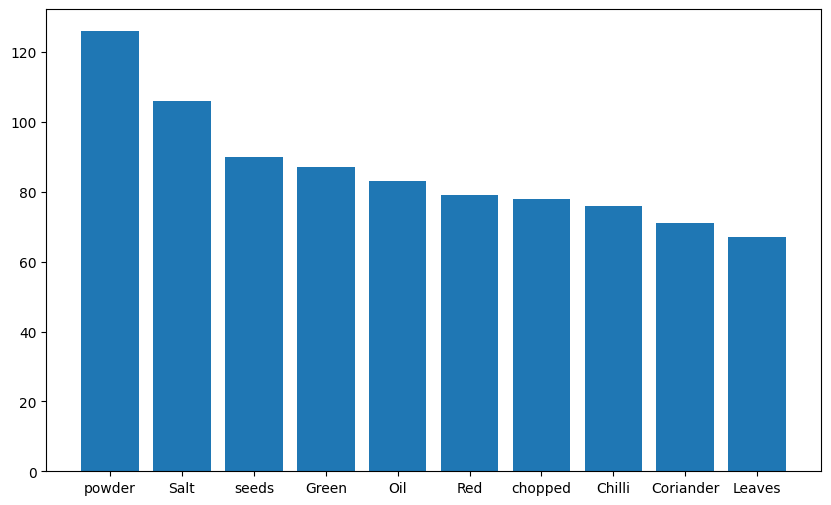

In [56]:
# plot the top frequent ingredients in training data
plot_top_items(ingradients)

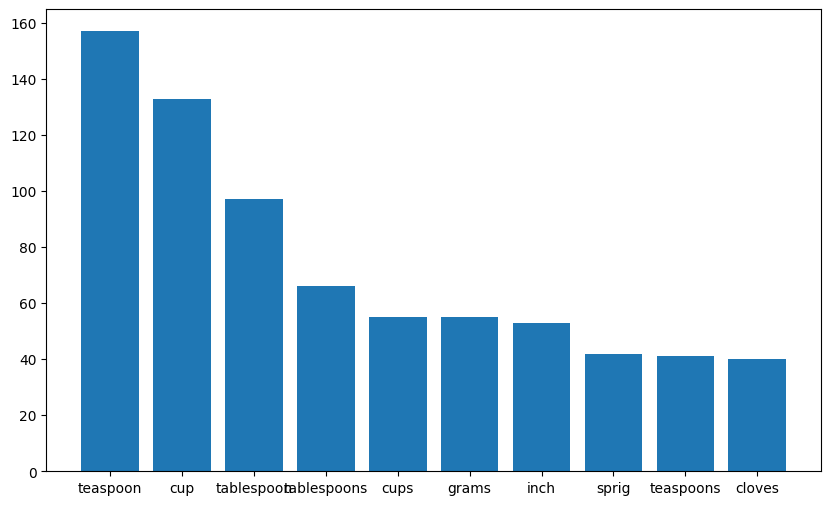

In [57]:
# plot the top frequent units in training data
plot_top_items(units)

## **5** Exploratory Recipe Data Analysis on Validation Dataset (Optional)<font color = red> [0 marks]</font> <br>

#### **5.1** *Execute EDA on Validation Dataset with insights (Optional)* <font color = red> [0 marks]</font> <br>
Initialise the dataset_name as ***Validation*** and call the ***plot_top_items*** for top 10 ingredients and units in the recipe data
Provide the insights for the same.



In [58]:
# initialise the dataset_name


In [59]:
# use extract and validate tokens, categorise tokens, get top frequent items for ingredient list and unit list on validation dataframe


In [60]:
# plot the top frequent ingredients in validation data


In [61]:
# plot the top frequent units in training data


## **6** Feature Extraction For CRF Model <font color = red>[30 marks]</font> <br>

### **6.1** *Define a feature functions to take each token from recipe* <font color = red>[10 marks]</font>

Define a function as ***word2features*** which takes a particular recipe and its index to work with all recipe input tokens and include custom key-value pairs.

Also, use feature key-value pairs to mark the beginning and end of the sequence and to also check whether the word belongs to unit, quantity etc. Use keyword sets for unit and quantity for differentiating feature functions well. Also make use of relevant regex patterns on fractions, whole numbers etc.

##### **6.1.1** **Define keywords for unit and quantity and create a quantity pattern to work on fractions, numbers and decimals** <font color = red>[3 marks]</font> <br>

Create sets for **unit_keywords** and ***quantity_keywords*** and include all the words relevant for measuring the ingredients such as cup, tbsp, tsp etc. and in quantity keywords, include words such as half, quarter etc.

Also suggested to use regex pattern as ***quantity_pattern*** to work with quantity in any format such as fractions, numbers and decimals.

Then, load the spacy model and process the entire sentence

In [62]:
# define unit and quantity keywords along with quantity pattern
import re
unit_keywords = {'cup', 'cups', 'c', 'tbsp', 'tbsps', 'tablespoon', 'tablespoons', 'tsp', 'tsps', 'teaspoon', 'teaspoons', 'oz', 'ounce', 'ounces', 'g', 'gram', 'grams', 'kg', 'kilogram', 'kilograms', 'lb', 'lbs', 'pound', 'pounds', 'ml', 'milliliter', 'milliliters', 'l', 'liter', 'liters', 'clove', 'cloves', 'pinch', 'pinches', 'dash', 'dashes', 'sprig', 'sprigs', 'stalk', 'stalks', 'slice', 'slices'}
quantity_keywords = {'half', 'quarter', 'one', 'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'ten', 'a', 'an'}
quantity_pattern = re.compile(r'(\d+\s+\d/\d|\d+/\d|\d+\.\d+|\d+)')

In [63]:
# load spaCy model
import spacy
nlp = spacy.load("en_core_web_sm")

##### **6.1.2** **Define feature functions for CRF** <font color = red>[7 marks]</font> <br>

Define ***word2features*** function and use the parameters such as sentence and its indexing as ***sent*** and ***i*** for extracting token level features for CRF Training.
Build ***features*** dictionary, also mark the beginning and end of the sequence and use the ***unit_keywords***, ***quantity_keywords*** and ***quantity_pattern*** for knowing the presence of quantity or unit in the tokens

While building ***features*** dictionary, include
- ***Core Features*** - The core features of a token should capture its lexical
and grammatical properties. Include attributes like the raw token, its lemma, part-of-speech tag, dependency relation, and shape, as well as indicators for whether it's a stop word, digit, or punctuation. The details of the features are given below:

    - `bias` - Constant feature with a fixed value of 1.0 to aid model learning.
    - `token` - The lowercase form of the current token.
    - `lemma` - The lowercase lemma (base form) of the token.
    - `pos_tag` - Part-of-speech (POS) tag of the token.
    - `tag` - Detailed POS tag of the token.
    - `dep` - Dependency relation of the token in the sentence.
    - `shape` - Shape of the token (e.g., "Xxx" for "Milk").
    - `is_stop` - Boolean indicating if the token is a stopword.
    - `is_digit` - Boolean indicating if the token consists of only digits.
    - `has_digit` - Boolean indicating if the token contains at least one digit.
    - `has_alpha` - Boolean indicating if the token contains at least one alphabetic character.
    - `hyphenated` - Boolean indicating if the token contains a hyphen (-).
    - `slash_present` - Boolean indicating if the token contains a slash (/).
    - `is_title` - Boolean indicating if the token starts with an uppercase letter.
    - `is_upper` - Boolean indicating if the token is fully uppercase.
    - `is_punct` - Boolean indicating if the token is a punctuation mark.

- ***Improved Quantity and Unit Detection*** - Use key-value pairs to mark the presence of quantities and units in the features dictionary. Utilise the unit_keywords, quantity_keywords, and quantity_pattern to identify and flag these elements. The details of the features are given below:

    - `is_quantity` - Boolean indicating if the token matches a quantity pattern or keyword.
    - `is_unit` - Boolean indicating if the token is a known measurement unit.
    - `is_numeric` - Boolean indicating if the token matches a numeric pattern.
    - `is_fraction` - Boolean indicating if the token represents a fraction (e.g., 1/2).
    - `is_decimal` - Boolean indicating if the token represents a decimal number (e.g., 3.14).
    - `preceding_word` - The previous token in the sentence, if available.
    - `following_word` - The next token in the sentence, if available.

- ***Contextual Features*** - Incorporate contextual information by adding features for the preceding and following tokens. Include indicators like BOS and EOS to mark the beginning and end of the sequence, and utilise unit_keywords, quantity_keywords, and quantity_pattern to identify the types of neighboring tokens. The features are given below:

    - `prev_token` - The lowercase form of the previous token.
    - `prev_is_quantity` - Boolean indicating if the previous token is a quantity.
    - `prev_is_digit` - Boolean indicating if the previous token is a digit.
    - `BOS` - Boolean indicating if the token is at the beginning of the sentence.
    - `next_token` - The lowercase form of the next token.
    - `next_is_unit` - Boolean indicating if the next token is a unit.
    - `next_is_ingredient` - Boolean indicating if the next token is not a unit or quantity.
    - `EOS` - Boolean indicating if the token is at the end of the sentence.



In [64]:
# define word2features for processing each token in the sentence sent by using index i.
# use your own feature functions

def word2features(sent,i):


    # Process the entire sentence with spaCy
    sentance = sent
    token = sentance[i]
    features = {}
    # --- Core Features ---
    features["bias"] = 1.0
    features['token'] = token.text.lower()
    features['lemma'] = token.lemma
    features['pos_tag'] = token.pos_
    features['dep']   = token.dep_
    features['shape'] = token.shape_
    features['is_stop'] = token.is_stop
    features['is_digit']= token.is_digit
    features['has_digit'] = any(char.isdigit() for char in token.text)
    features['has_alpha']= any(char.isalpha() for char in token.text)
    features['hyphenated']= '-' in token.text
    features['slash_present']= '/' in token.text
    features['is_title'] = token.is_title
    features['is_upper'] = token.is_upper
    features['is_punct'] = token.is_punct

    # --- Improved Quantity & Unit Detection ---
    features['is_quantity'] =( token.text.lower() in quantity_keywords or
                              bool(quantity_pattern.match(token.text)))
    features['is_unit'] = token.text.lower() in unit_keywords
    features['is_numeric'] = token.like_num
    #features['is_fraction'] = '/' in token.text and all(
    #   part.is_digit() for part in token.text.split('/')
    #)
    #features['is_dicimal'] = token.text.replace('.', '').isdigit() and '.' in token.text

    # --- Contextual Features ---
    if i > 0:
        prev_token = sentance[i-1]
        features['prev_token'] = prev_token.text.lower()
        features['prev_is_quantity'] = (
            prev_token.text.lower() in quantity_keywords or
            bool(quantity_pattern.match(prev_token.text))
        )
        features['prev_is_digit'] = prev_token.is_digit
    else:
        # Mark beginning of sentence (BOS)
        features['BOS'] = True

    # Features for the next token
    if i < len(sentance) - 1:
        next_token = sentance[i+1]
        features['next_token'] = next_token.text.lower()
        features['next_is_unit'] = next_token.text.lower() in unit_keywords
        features['next_is_ingredient'] = not (
            bool(quantity_pattern.match(next_token.text)) or
            next_token.text.lower() in unit_keywords or
            next_token.text.lower() in quantity_keywords
        )
    else:
        features['EOS'] = True

    return features

### **6.2** *Preparation of Recipe level features* <font color = red>[2 marks]</font>


##### **6.2.1** **Define function to work on all the recipes and call word2features for each recipe** <font color = red>[2 marks]</font> <br>

Define ***sent2features*** function and inputs ***sent*** as a parameter and correctly generate feature functions for each token present in the sentence

In [65]:
# define sent2features by working on each token in the sentence and correctly generate dictionaries for features
def sent2features(sent):
    return [word2features(sent, i) for i in range(len(sent))]

### **6.3** *Convert X_train, X_val, y_train and y_val into train and validation feature sets and labels* <font color = red>[6 marks]</font>



##### **6.3.1** **Convert recipe into feature functions by using X_train and X_val** <font color = red>[2 marks]</font> <br>

Create ***X_train_features*** and ***X_val_features*** as list to include the feature functions for each recipe present in training and validation sets

In [66]:
# Convert input sentences into feature sets by taking training and validation dataset as X_train_features and X_val_featuresX
X_train = train_df["input"]
X_val = val_df["input"]

docs =  X_train.values.tolist()
#print(docs)
X_train_features = [sent2features(nlp(doc)) for doc in docs]
print(len(X_train_features[3]))

docs2 =  X_val.values.tolist()
X_val_features = [sent2features(nlp(doc)) for doc in docs2]



32


##### **6.3.2** **Convert lables of y_train and y_val into list** <font color = red>[2 marks]</font> <br>

Create ***y_train_labels*** and ***y_val_labels*** by using the list of y_train and y_val

In [67]:
# Convert labels into list as y_train_labels and y_val_labels
y_train_labels = y_train.values.tolist()
y_val_labels = y_val.values.tolist()
print(len(y_train_labels),len(y_val_labels))


195 84


##### **6.3.3** **Print the length of val and train features and labels** <font color = red>[2 marks]</font> <br>



In [68]:
# print the length of train features and labels
print(len(X_train_features),len(y_train_labels))

195 195


In [69]:
# print the length of validation features and labels
print(len(X_val_features),len(y_val_labels))

84 84


### **6.4** *Applying weights to feature sets* <font color = red>[12 marks]</font> <br>




##### **6.4.1** **Flatten the labels of y_train** <font color = red>[2 marks]</font> <br>

Create ***y_train_flat*** to flatten the structure of nested y_train

In [70]:
# Flatten labels in y_train
y_train_flat = [label for sublist in y_train for label in sublist]
print(y_train_flat)

['quantity', 'unit', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'unit', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'quantity', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'unit', 'ingredient', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'ingredient', 'ingredient', 'quantity', 'quantity', 'unit', 'ingredient', 'ingredient', '

##### **6.4.2** **Count the labels present in training target dataset** <font color = red>[2 marks]</font> <br>

Create ***label_counts*** to count the frequencies of labels present in y_train_flat and retrieve the total samples by using the values of label_counts as ***total_samples***

In [71]:
# Count label frequencies as label_counts and total_samples as getting the summation of values of label_counts

label_counts = {label: y_train_flat.count(label) for label in set(y_train_flat)}
total_samples = sum(label_counts.values())

print("\nLabel counts:")
print(label_counts)

print("\nTotal samples:")
print(total_samples)


Label counts:
{'ingredient': 5229, 'unit': 815, 'quantity': 965}

Total samples:
7009


##### **6.4.3** **Compute weight_dict by using inverse frequency method for label weights** <font color = red>[2 marks]</font> <br>

- Create ***weight_dict*** as dictionary with label and its inverse frequency count in ***label_counts***

- Penalise ingredient label in the dictionary

In [72]:
# Compute class weights (inverse frequency method) by considering total_samples and label_counts

class_weights = {label: total_samples / count for label, count in label_counts.items()}
print("\nClass weights :")
print(class_weights)


Class weights :
{'ingredient': 1.3404092560719068, 'unit': 8.6, 'quantity': 7.263212435233161}


In [73]:
# penalise ingredient label
penalized_weights = class_weights.copy()

for label, weight in penalized_weights.items():
        if 'ingredient' in label:
            penalized_weights[label] = weight * 0.5

print("\nPenalized class weights:")
print(penalized_weights)


Penalized class weights:
{'ingredient': 0.6702046280359534, 'unit': 8.6, 'quantity': 7.263212435233161}


##### **6.4.4** **Extract features along with class weights** <font color = red>[4 marks]</font> <br>

Define a function ***extract_features_with_class_weights*** to work with training and validation datasets and extract features by applying class weights





In [74]:
# Apply weights to feature extraction in extract_features_with_class_weights by using parameters such as X (input tokens), y(labels) and weight_dict (Class weights)
def extract_features_with_class_weights(X, y, weight_dict):
  docs =  X.values.tolist()
  X_features = [sent2features(nlp(doc)) for doc in docs]
  y_labels = y.values.tolist()
  return X_features,y_labels


##### **6.4.5** **Execute extract_features_with_class_weights on training and validation datasets** <font color = red>[2 marks]</font> <br>

Create ***X_train_weighted_features*** and ***X_val_weighted_features*** for extracting training and validation features along with their weights by calling ***extract_features_with_class_weights*** on the datasets

In [75]:
# Apply manually computed class weights
X_train_weighted_features, y_train_weighted_labels = extract_features_with_class_weights(
    X_train, y_train, penalized_weights )
X_val_weighted_features, y_val_weighted_labels = extract_features_with_class_weights(
    X_val, y_val, penalized_weights )
print(len(X_train_weighted_features[10]),len(y_train_weighted_labels[10]))

20 20


In [80]:
import sklearn_crfsuite

from sklearn_crfsuite import metrics
crf = sklearn_crfsuite.CRF(
    algorithm='lbfgs',
    c1=0.1,  # L1 regularization coefficient
    c2=1.0,  # L2 regularization coefficient
    max_iterations=100,
    all_possible_transitions=True)
crf.fit(X_train, y_train)

CRF(algorithm='lbfgs', all_possible_transitions=True, c1=0.1, c2=1.0,
    max_iterations=100)

## **7** Model Building and Training <font color = red>[10 marks]</font> <br>

### **7.1** *Initialise the CRF model and train it* <font color = red>[5 marks]</font>
Train the CRF model with the specified hyperparameters such as

### CRF Model Hyperparameters Explanation

| Parameter                  | Description |
|----------------------------|-------------|
| **algorithm='lbfgs'**      | Optimisation algorithm used for training. `lbfgs` (Limited-memory Broyden–Fletcher–Goldfarb–Shanno) is a quasi-Newton optimisation method. |
| **c1=0.5**                | L1 regularisation term to control sparsity in feature weights. Helps in feature selection. |
| **c2=1.0**                | L2 regularisation term to prevent overfitting by penalising large weights. |
| **max_iterations=100**     | Maximum number of iterations for model training. Higher values allow more convergence but increase computation time. |
| **all_possible_transitions=True** | Ensures that all possible state transitions are considered in training, making the model more robust. |

Use weight_dict for training CRF



### **7.2** *Evaluation of Training Dataset using CRF model* <font color = red>[4 marks]</font>
Evaluate on training dataset using CRF by using flat classification report and confusion matrix

In [81]:
# evaluate on the training dataset
y_pred = crf.predict(X_train)
metrics.flat_f1_score(y_train, y_pred, average='weighted')


0.9727861300304941

In [82]:
# specify the flat classification report by using training data for evaluation

y_true_flat = list(itertools.chain.from_iterable(y_train_labels))
y_pred_flat = list(itertools.chain.from_iterable(y_pred))
labels = sorted(list(set(y_true_flat)))

# Print the classification report
print("\nFlat Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, labels=labels, zero_division=0))



Flat Classification Report:
              precision    recall  f1-score   support

  ingredient       0.98      0.98      0.98      5229
    quantity       0.99      0.98      0.99       965
        unit       0.91      0.89      0.90       815

    accuracy                           0.97      7009
   macro avg       0.96      0.95      0.96      7009
weighted avg       0.97      0.97      0.97      7009



In [83]:
# create a confusion matrix on training datset
print("\nConfusion Matrix:")
# Get the unique labels to use as columns and rows
labels = sorted(list(set(y_true_flat)))
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

print("Labels order:", labels)
print(conf_matrix)


Confusion Matrix:
Labels order: ['ingredient', 'quantity', 'unit']
[[5148    8   73]
 [  16  948    1]
 [  92    0  723]]


### **7.3** *Save the CRF model* <font color = red>[1 marks]</font>
Save the CRF model

In [91]:
# dump the model using joblib as crf_model.pkl
import joblib

# Assuming 'crf_model' is your trained model object
# Replace 'crf_model' with the actual variable holding your trained model
joblib.dump(crf, 'crf_model.pkl')


['crf_model.pkl']

## **8** Prediction and Model Evaluation <font color = red>[3 marks]</font> <br>

### **8.1** *Predict and Evaluate the CRF model on validation set* <font color = red>[3 marks]</font>
Evaluate the metrics for CRF model by using flat classification report and confusion matrix




In [84]:
# predict the crf model on validation dataset
y_pred_val = crf.predict(X_val)
metrics.flat_f1_score(y_val, y_pred_val, average='weighted')


0.9684276283557585

In [85]:
# specify flat classification report
y_true_flat = list(itertools.chain.from_iterable(y_val_labels))
y_pred_flat = list(itertools.chain.from_iterable(y_pred_val))
labels = sorted(list(set(y_true_flat)))

# Print the classification report
print("\nFlat Classification Report:")
print(classification_report(y_true_flat, y_pred_flat, labels=labels, zero_division=0))



Flat Classification Report:
              precision    recall  f1-score   support

  ingredient       0.98      0.98      0.98      2146
    quantity       0.99      0.99      0.99       416
        unit       0.88      0.88      0.88       347

    accuracy                           0.97      2909
   macro avg       0.95      0.95      0.95      2909
weighted avg       0.97      0.97      0.97      2909



In [86]:
# create a confusion matrix on validation dataset
# create a confusion matrix on training datset
print("\nConfusion Matrix:")
# Get the unique labels to use as columns and rows
labels = sorted(list(set(y_true_flat)))
conf_matrix = confusion_matrix(y_true_flat, y_pred_flat, labels=labels)

print("Labels order:", labels)
print(conf_matrix)


Confusion Matrix:
Labels order: ['ingredient', 'quantity', 'unit']
[[2100    3   43]
 [   6  410    0]
 [  39    1  307]]


## **9** Error Analysis on Validation Data <font color = red>[10 marks]</font> <br>
Investigate misclassified samples in validation dataset and provide the insights


### **9.1** *Investigate misclassified samples in validation dataset* <font color = red>[8 marks]</font>



##### **9.1.1** Flatten the labels of validation data and initialise error data <font color = red>[2 marks]</font> <br>



Flatten the true and predicted labels and initialise the error data as ***error_data***

In [87]:
# flatten Labels and Initialise Error Data
y_pred_val_flat = list(itertools.chain.from_iterable(y_pred_val))

# Initialize the error data dictionary
error_data = {}

##### **9.1.2** Iterate the validation data and collect Error Information<font color = red> [2 marks]</font> <br>



Iterate through validation data (X_val, y_val_labels, y_pred_val) and compare true vs. predicted labels. Collect error details, including surrounding context, previous/next tokens, and class weights, then store them in error_data

In [88]:
# iterate and collect Error Information
for i, (sentence, true_labels, pred_labels) in enumerate(zip(X_val, y_val_labels, y_pred_val)):
    # Check if the sentence is a string before processing with nlp()
    if not isinstance(sentence, str):
        # This condition handles the ValueError, although it should not be hit
        # with the current X_val.
        print(f"Skipping invalid input at index {i}: expected string, got {type(sentence)}")
        continue

    # Convert the sentence into a list of tokens
    tokens = [token.text for token in nlp(sentence)]

    # Iterate through the tokens of the current sentence
    for j, (token, true_label, pred_label) in enumerate(zip(tokens, true_labels, pred_labels)):
        # Check if the predicted label is incorrect
        if true_label != pred_label:
            # Store the error details
            error_details = {
                'sentence_index': i,
                'token_index': j,
                'token': token,
                'true_label': true_label,
                'predicted_label': pred_label,
                'context_before': tokens[max(0, j-2):j],
                'context_after': tokens[j+1:min(len(tokens), j+3)],
                'true_label_weight': penalized_weights.get(true_label, 0),
                'predicted_label_weight': penalized_weights.get(pred_label, 0)
            }
            # Append the error details to the error_data dictionary
            if error_data.get('errors'):
                error_data['errors'].append(error_details)
            else:
                error_data['errors'] = [error_details]

print("\nError analysis complete. Error details stored in 'error_data'.")
print("Example of a single error entry:")
if error_data:
    print(error_data['errors'][0])
else:
    print("No errors found in the validation data.")



Skipping invalid input at index 0: expected string, got <class 'list'>
Skipping invalid input at index 1: expected string, got <class 'list'>
Skipping invalid input at index 2: expected string, got <class 'list'>
Skipping invalid input at index 3: expected string, got <class 'list'>
Skipping invalid input at index 4: expected string, got <class 'list'>
Skipping invalid input at index 5: expected string, got <class 'list'>
Skipping invalid input at index 6: expected string, got <class 'list'>
Skipping invalid input at index 7: expected string, got <class 'list'>
Skipping invalid input at index 8: expected string, got <class 'list'>
Skipping invalid input at index 9: expected string, got <class 'list'>
Skipping invalid input at index 10: expected string, got <class 'list'>
Skipping invalid input at index 11: expected string, got <class 'list'>
Skipping invalid input at index 12: expected string, got <class 'list'>
Skipping invalid input at index 13: expected string, got <class 'list'>
Sk

##### **9.1.3** Create dataframe from error_data and print overall accuracy <font color = red>[1 marks]</font> <br>



Change error_data into dataframe and then use it to illustrate the overall accuracy of validation data

In [89]:
# Create DataFrame and Print Overall Accuracy
if 'errors' in error_data and error_data['errors']:
    error_df = pd.DataFrame(error_data['errors'])
    print("Error Data as a DataFrame:")
    print(error_df)
else:
    print("No errors found in the validation data. No DataFrame created.")


No errors found in the validation data. No DataFrame created.


##### **9.1.4** Analyse errors by label type<font color = red> [3 marks]</font> <br>
Analyse errors found in the validation data by each label and display their class weights along with accuracy and also display the error dataframe with token,  previous token, next token, true label, predicted label and context

In [90]:
# Analyse errors found in the validation data by each label
# and display their class weights along with accuracy
# and display the error dataframe with token, previous token, next token, true label, predicted label and context
if 'errors' in error_data and error_data['errors']:
  error_summary = error_df.groupby(['true_label', 'predicted_label']).size().reset_index(name='count')

  for index, row in error_summary.iterrows():
        true_label = row['true_label']
        predicted_label = row['predicted_label']
        count = row['count']

        true_weight = penalized_weights.get(true_label, 'N/A')
        predicted_weight = penalized_weights.get(predicted_label, 'N/A')

        print(f"Error: {count} instances where '{true_label}' was predicted as '{predicted_label}'")
        print(f"  - True Label Weight: {true_weight:.2f}")
        print(f"  - Predicted Label Weight: {predicted_weight:.2f}")

  print("\n--- Error DataFrame ---")

    # Create a simplified DataFrame for display
  error_df['context'] = error_df['context_before'].apply(lambda x: ' '.join(x)) + ' ' + error_df['context_after'].apply(lambda x: ' '.join(x))
  display_df = error_df[['token', 'context', 'true_label', 'predicted_label']]
  print(display_df)



### **9.2** *Provide insights from the validation dataset* <font color = red>[2 marks]</font>




 <font color = red>[Write your answer]</font>

This is good exercise covering all aspects of the NLP.  Overall the modle built performed well both the test and validation data set with good predection scors.

## **10** Conclusion (Optional) <font color = red>[0 marks]</font> <br>

Write your findings and conclusion.